# Differential Quantum Circuits (DQCs)

In [122]:
# Library imports
import matplotlib.pyplot as plt
import numpy as np
from qadence import *
from torch import (
    nn,
    optim,
    tensor,
    ones_like,
    rand,
    linspace,
    manual_seed,
    tan
)
from torch.autograd import grad

In [123]:
# Random seed
manual_seed(42)

# Hyperparameters
learning_rate = 0.01
n_qubits = 4
depth = 8
variable = ["x"]
n_points = 60
n_epochs = 1000
lam = 8
k = 0.1

In [124]:
# Helper function to calculate derivatives
def calc_derivative(outputs, inputs) -> tensor:
    """
    Returns the derivative of a function output
    with respect to its inputs.
    """
    if not inputs.requires_grad:
        inputs.requires_grad = True
    return grad(
        inputs=inputs,
        outputs=outputs,
        grad_outputs=ones_like(outputs),
        create_graph=True,
        retain_graph=True,
    )[0]


In [125]:
class loss_function(nn.Module):
    def __init__(self, net: nn.Module | QNN, n_inputs: int = 1, n_colpoints: int = 20):
        super().__init__()
        self.net = net
        self.n_colpoints = n_colpoints
        self.n_inputs = n_inputs

    def left_boundary(self) -> tensor:  # u(0) = 1
        sample = torch.zeros(size=(self.n_colpoints, self.n_inputs))
        return (self.net(sample) - 1).pow(2).mean()

    def interior(self) -> tensor:
        sample = rand(size=(self.n_colpoints, self.n_inputs), requires_grad=True)
        first_deriv = calc_derivative(self.net(sample), sample)
        return (first_deriv + (lam * self.net(sample) * (k + tan(lam * sample)))).pow(2).mean()

In [126]:
# Define a simple DQC model
ansatz = hea(n_qubits=n_qubits, depth=depth,operations=[RZ,RX,RZ])

# Feature map
fm = feature_map(
    n_qubits=n_qubits,
    param="x",
    fm_type=BasisSet.CHEBYSHEV,
    reupload_scaling=ReuploadScaling.TOWER,
)
obs = ising_hamiltonian(n_qubits=n_qubits)

# Building the circuit and the quantum model
circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
model = QNN(circuit=circuit, observable=obs, inputs=variable)

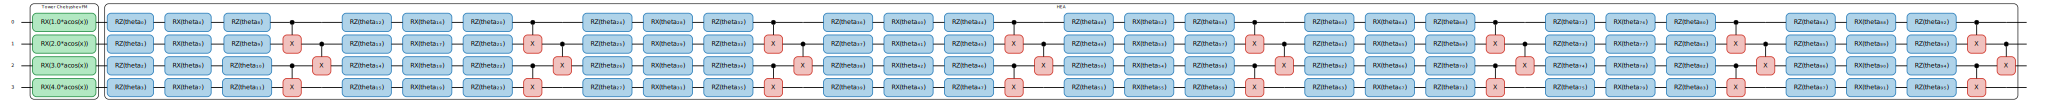

In [127]:
from qadence.draw import display

display(circuit)

In [128]:
opt = optim.AdamW(model.parameters(), lr=learning_rate)
sol = loss_function(net=model, n_inputs=1, n_colpoints=100)

# Training
for epoch in range(n_epochs + 1):
    opt.zero_grad()
    loss = (
        45*sol.left_boundary()
        + sol.interior())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    opt.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item()}")

Epoch 0/1000, Loss: 9514.303369217037
Epoch 100/1000, Loss: 17.86642639522873
Epoch 200/1000, Loss: 201.60395391176513
Epoch 300/1000, Loss: 129.52693336070595
Epoch 400/1000, Loss: 29.378266433405518
Epoch 500/1000, Loss: 0.980396713887747
Epoch 600/1000, Loss: 5.750855309749282
Epoch 700/1000, Loss: 17.803880731741433
Epoch 800/1000, Loss: 148.852406171105
Epoch 900/1000, Loss: 2.281147411897569
Epoch 1000/1000, Loss: 20.09056633659595


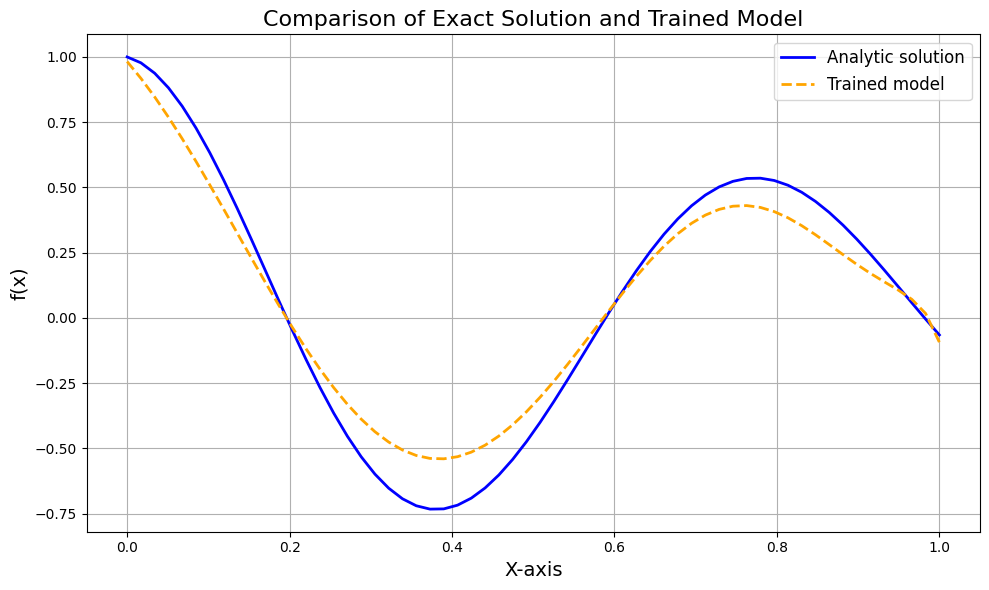

In [129]:
# Visualization and comparison of results
domain = linspace(0, 1, steps=n_points)

# Analytical solution
analytic_sol = (np.exp(-k * lam * domain) * np.cos(lam * domain))

# DQC solution
dqc_sol = model(domain).reshape(n_points).detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(domain, analytic_sol, label="Analytic solution", color='blue', linestyle='-', linewidth=2)
plt.plot(domain, dqc_sol, label="Trained model", color='orange', linestyle='--', linewidth=2)
plt.title("Comparison of Exact Solution and Trained Model", fontsize=16)
plt.xlabel("X-axis", fontsize=14)
plt.ylabel("f(x)", fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()